In [16]:
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Set sklearn output to pandas dataframes
from sklearn import set_config
set_config(transform_output='pandas')

In [17]:
import optuna
import logging
import warnings

import warnings
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

logger = logging.getLogger()

logger.setLevel(logging.INFO)  # Setup the root logger.
logger.addHandler(logging.FileHandler("./cache/optuna.log", mode="w"))

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

base_path = './prod/all'

def get_study(name, metric='r2'):
    # create or load the study
    study = optuna.study.create_study(
        storage=f'sqlite:///{base_path}/cache/optuna.db',
        load_if_exists=True,
        direction='maximize',
        study_name=name,
        sampler=optuna.samplers.TPESampler(n_startup_trials=20)
    )
    study.set_metric_names([metric])
    return study


# Read the data

In [18]:
from src.selectvar import get_data

if base_path != './prod/health':
    X, y, nominal, ordinal, discrete, continues, rel = get_data(target='plh0182')
else:
    X, y, nominal, ordinal, discrete, continues, rel = get_data(target='mcs')

# Manual preprocessing

In [19]:
def remove_duplicate_prefixes(strings):
    selected_strings = []
    removed_strings = []
    seen_prefixes = set()
    for string in strings:
        prefix = string.split('_')[0]
        if prefix not in seen_prefixes:
            seen_prefixes.add(prefix)
            selected_strings.append(string)
        else:
            removed_strings.append(string)
    return removed_strings

In [20]:
# Manuall dropping of variables (very clear cases)
columns_to_drop = [
    'pid', 'hid', 'cid', 'intid', 'h_pnr', 'pnr', 'time', 'bula', # key columns
    'fweight', 'fheight', 'valid', # imputation flags
    #'pcs', 'mcs', #pca of other variables
    'pf_nbs', 'rp_nbs', 'bp_nbs', 'gh_nbs', 'vt_nbs', 'sf_nbs', 're_nbs', 'mh_nbs', 'plh0182'
]

# Drop columns with same prefixes -> means carry same information
columns_to_drop += remove_duplicate_prefixes(X.columns.tolist())
# Drop all subjective columns
if base_path != './prod/all':
    columns_to_drop += rel

X = X.drop(columns=columns_to_drop, errors='ignore')

# Update variable types
nominal = [x for x in nominal if x in X.columns]
ordinal = [x for x in ordinal if x in X.columns]
discrete = [x for x in discrete if x in X.columns]
continues = [x for x in continues if x in X.columns]

# cast dtypes
X, y = X.astype(float), y.astype(float)
# drop nans
X[X<0], y[y<0] = np.nan, np.nan # soep convention
df = pd.concat([X, y], axis=1)
df.dropna(inplace=True)
X, y = df.iloc[:,:-1], df.iloc[:,-1]


In [21]:
import pickle

# save data
pickle.dump([X, y, nominal, ordinal, discrete, continues, rel], open(f'{base_path}/data.pkl', "wb"))

# Data Vizualisation

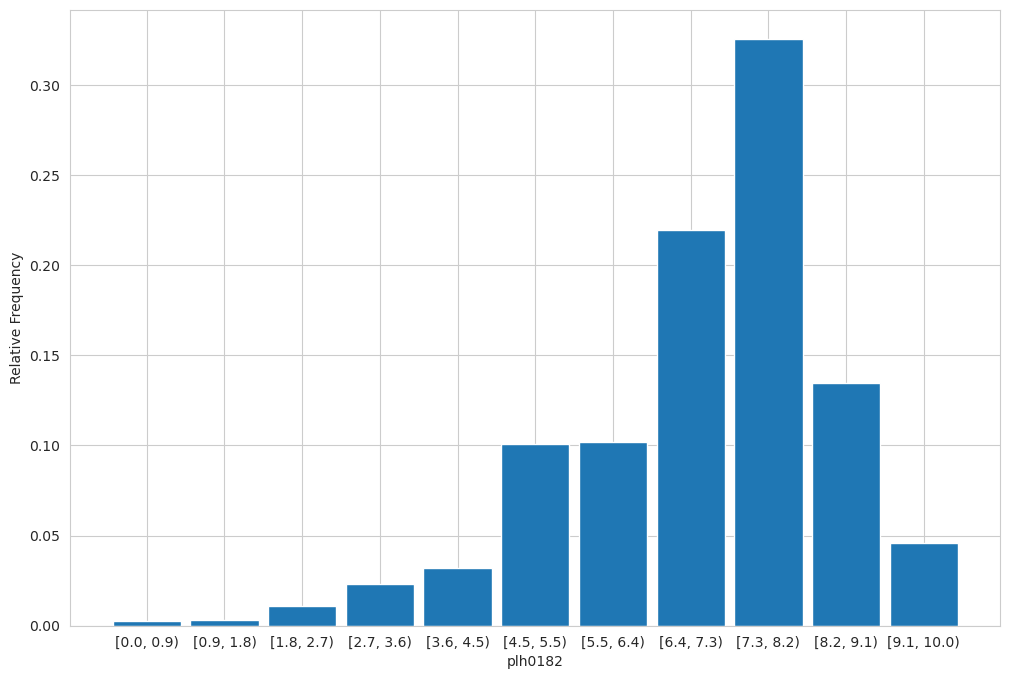

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

counts, cats = np.histogram(y, bins=11)
cats_labels = np.array([f'[{l:.1f}, {r:.1f})' for l, r in zip(cats[:-1], cats[1:])])
cats = cats[:-1]

counts = counts / np.sum(counts)

ax.bar(cats, counts)
ax.set_ylabel("Relative Frequency")
ax.set_xlabel(y.name)
ax.set_xticks(cats, cats_labels)
plt.savefig(f'{base_path}/plots/target_dist.pdf', dpi=300)

# Split the data

We split the data into train and test s.t. we can evalueate the models performance in the end.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33
)

# Preprocessing

In the following different preprocessing pipelines are defined. We use different pipelines to check in the end if there is a difference in performance.

Here we check which parameter to use for the `DropHighMICategorical` class. That class drops columns that share a lot of information with other variabels.

Now that we checked the preprocessing we can build out pipeline.

In [24]:
from sklearn.metrics import adjusted_mutual_info_score

# custom mutual information function
def custom_mi_reg(a, b):
    a = np.ravel(a)
    b = np.ravel(b)
    return  adjusted_mutual_info_score(a, b)

corr_mat = X_train.loc[:, discrete + continues].corr().abs().values
mi_mat = X_train.loc[:, nominal + ordinal].corr(method=custom_mi_reg).values

x_values = np.arange(0, 1.001, 0.005)
mi_results = np.zeros_like(x_values)
corr_results = np.zeros_like(x_values)
for i, v in enumerate(x_values):
    mi_results[i] = (np.sum(mi_mat >= v) - mi_mat.shape[1]) // 2
    corr_results[i] = (np.sum(corr_mat >= v) - corr_mat.shape[1]) // 2

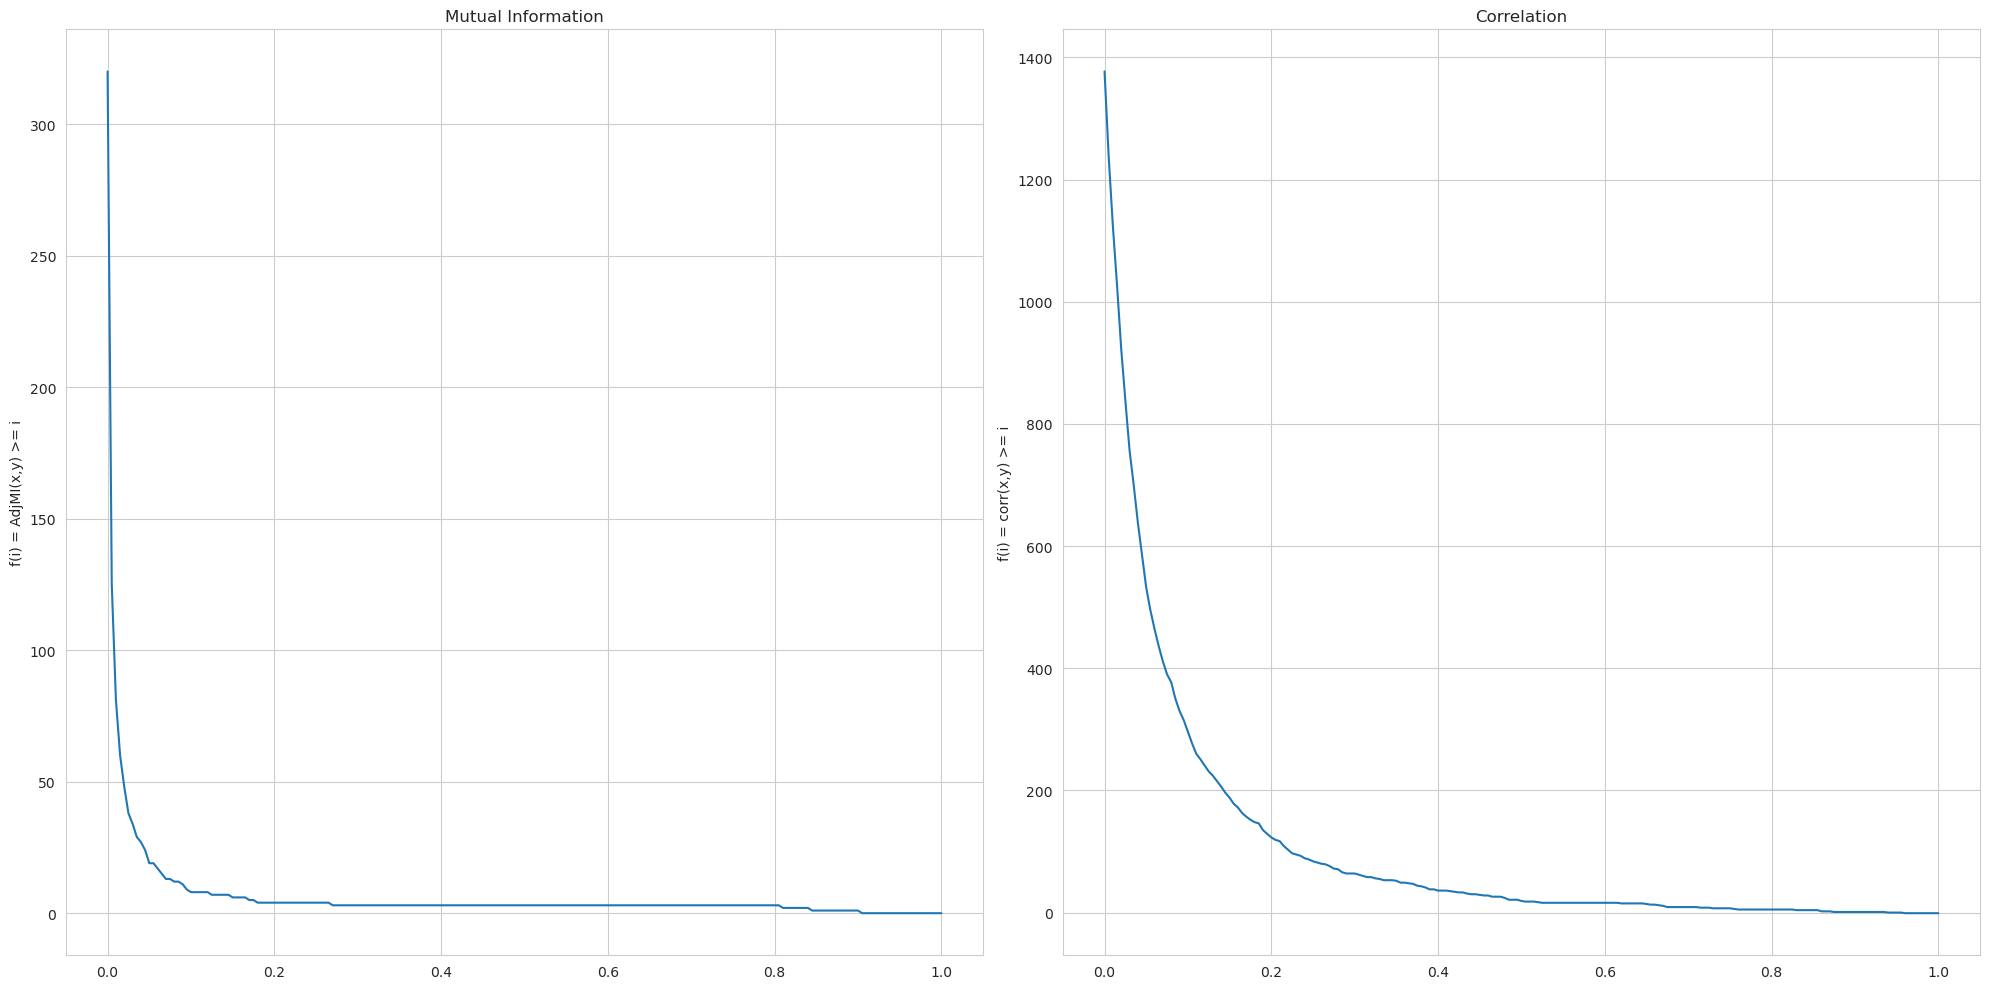

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(x_values, mi_results)
ax1.set_ylabel('f(i) = AdjMI(x,y) >= i')
ax1.set_title('Mutual Information')

ax2.plot(x_values, corr_results)
ax2.set_ylabel('f(i) = corr(x,y) >= i')
ax2.set_title('Correlation')
plt.tight_layout()

In [26]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import ColumnTransformer

ordinal_transformer = OrdinalEncoder()
continues_transformer = StandardScaler()
discrete_transformer = MinMaxScaler()

ct_ohe = ColumnTransformer(
    transformers=[
        ('n', OneHotEncoder(cols=nominal), nominal),
        ('o', ordinal_transformer, ordinal),
        ('d', discrete_transformer, discrete),
        ('c', continues_transformer, continues)
    ]
)

ct_label = ColumnTransformer(
    transformers=[
        ('n', 'passthrough', nominal),
        ('o', ordinal_transformer, ordinal),
        ('d', discrete_transformer, discrete),
        ('c', continues_transformer, continues)
    ]
)

# Feature selection

First it must be determined which features should be included in the analysis. Currently there are many variables in the dataset of which most do probabliy not have any relationship with well-being. To select the most important features we want to train some baseline models on the complete dataset and use feature importance measures to select the variables that are highly used by the model.

To assure the robustness of the variable selection we do the following:
- First of all we will rely on the results that are produced by a mutitude of different models. The assumption here is that should a feature be important in one model, then it should also be important in others. The hyper-parameters are tuned using basian optimization.
- Each model is evaluated using bootstrapping.

In [27]:
from src.selectvar import BootstrapSampler

#custom_cv = StratifiedKFold(n_splits=3, shuffle=True)
custom_cv = BootstrapSampler(40_000, 40_000, 4, n_test=0.5)

In [28]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge

def lasso_suggestor(t):
    t.suggest_float('alpha', 0.001, 100, log=True)

def ridge_suggestor(t):
    t.suggest_float('alpha', 0.001, 100, log=True)

def hb_suggestor(t):
    t.suggest_int('max_iter', 1, 1001, 10)
    t.suggest_int('max_depth', 3, 20, 1)
    t.suggest_int('min_samples_leaf', 10, 400, step=10)
    t.suggest_float('l2_regularization', 0.001, 100, log=True)

def rf_suggestor(t):
    t.suggest_int('max_depth', 3, 20, 1)
    t.suggest_int('min_samples_leaf', 20, 200, step=10)
    t.suggest_float('max_features', 0.1, 1, step=0.1)
    t.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'poisson'])

# Define the models to optimize
lasso = Lasso(max_iter=10_000)
ridge = Ridge(max_iter=20_000, solver='lsqr')
rf = RandomForestRegressor(
    bootstrap=True,
    n_estimators=150
)
hb = HistGradientBoostingRegressor(
    learning_rate=0.01, early_stopping=True
)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

def transform_cross_validate(est, X, y, transformer):
    # Make Pipeline
    pl = Pipeline(
        steps=[
            ('t', transformer), 
            ('est', est)
        ]
    )
    # Evaluate
    return cross_validate(pl, X, y, cv=custom_cv, n_jobs=-1, scoring='r2', return_train_score=True, error_score='raise')


# Objective function for hp tuning
def objective(trial, est, suggestor, transformer):
    # suggest params
    suggestor(trial)
    est.set_params(**trial.params)

    results = transform_cross_validate(est, X_train, y_train, transformer)

    scores_test = np.mean(results["test_score"])

    return scores_test

# Train
study_ridge = get_study('ridge_hp')
study_ridge.optimize(lambda x: objective(x, ridge, ridge_suggestor, ct_label), n_trials=0, n_jobs=1)
print('Model is trained!')

study_lasso = get_study('lasso_hp')
study_lasso.optimize(lambda x: objective(x, lasso, lasso_suggestor, ct_label), n_trials=0, n_jobs=1)
print('Model is trained!')

study_rf = get_study('random_forest_hp')
study_rf.optimize(lambda x: objective(x, rf, rf_suggestor, ct_label), n_trials=0, n_jobs=1)
print('Model is trained!')

study_hb = get_study('hist_boost_hp')
study_hb.optimize(lambda x: objective(x, hb, hb_suggestor, ct_label), n_trials=0, n_jobs=1)
print('Model is trained!')

# With count
study_ridge_d = get_study('ridge_d_hp')
study_ridge_d.optimize(lambda x: objective(x, ridge, ridge_suggestor, ct_ohe), n_trials=40, n_jobs=1)
print('Model is trained!')

study_lasso_d = get_study('lasso_d_hp')
study_lasso_d.optimize(lambda x: objective(x, lasso, lasso_suggestor, ct_ohe), n_trials=40, n_jobs=1)
print('Model is trained!')

study_rf_d = get_study('random_forest_d_hp')
study_rf_d.optimize(lambda x: objective(x, rf, rf_suggestor, ct_ohe), n_trials=40, n_jobs=1)
print('Model is trained!')

study_hb_d = get_study('hist_boost_d_hp')
study_hb_d.optimize(lambda x: objective(x, hb, hb_suggestor, ct_ohe), n_trials=40, n_jobs=1)
print('Model is trained!')

Model is trained!
Model is trained!
Model is trained!
Model is trained!
Model is trained!
Model is trained!
Model is trained!
Model is trained!


In [30]:
from joblib import dump

# Retrain best models target
rf.set_params(**study_rf.best_params)
dump(rf, f'{base_path}/cache/optuna_rf.joblib')
rf_results = pd.DataFrame(transform_cross_validate(rf, X_train, y_train, ct_label))
rf_results['Model'] = 'Random Forest'
rf_results['Encoding'] = 'Label'

hb.set_params(**study_hb.best_params)
dump(hb, f'{base_path}/cache/optuna_hist.joblib')
hb_results = pd.DataFrame(transform_cross_validate(hb, X_train, y_train, ct_label))
hb_results['Model'] = 'Hist Gradient Boosting Regressor'
hb_results['Encoding'] = 'Label'

lasso.set_params(**study_lasso.best_params)
dump(lasso, f'{base_path}/cache/optuna_lasso.joblib')
lasso_results = pd.DataFrame(transform_cross_validate(lasso, X_train, y_train, ct_label))
lasso_results['Model'] = 'Lasso'
lasso_results['Encoding'] = 'Label'

ridge.set_params(**study_ridge.best_params)
dump(ridge, f'{base_path}/cache/optuna_ridge.joblib')
ridge_results = pd.DataFrame(transform_cross_validate(ridge, X_train, y_train, ct_label))
ridge_results['Model'] = 'Ridge'
ridge_results['Encoding'] = 'Label'

# Retrain best models dummy
rf.set_params(**study_rf_d.best_params)
dump(rf, f'{base_path}/cache/optuna_rf_d.joblib')
rf_results_d = pd.DataFrame(transform_cross_validate(rf, X_train, y_train, ct_ohe))
rf_results_d['Model'] = 'Random Forest'
rf_results_d['Encoding'] = 'OHE'

hb.set_params(**study_hb_d.best_params)
dump(hb, f'{base_path}/cache/optuna_hist_d.joblib')
hb_results_d = pd.DataFrame(transform_cross_validate(hb, X_train, y_train, ct_ohe))
hb_results_d['Model'] = 'Hist Gradient Boosting Regressor'
hb_results_d['Encoding'] = 'OHE'

lasso.set_params(**study_lasso_d.best_params)
dump(lasso, f'{base_path}/cache/optuna_lasso_d.joblib')
lasso_results_d = pd.DataFrame(transform_cross_validate(lasso, X_train, y_train, ct_ohe))
lasso_results_d['Model'] = 'Lasso'
lasso_results_d['Encoding'] = 'OHE'

ridge.set_params(**study_ridge_d.best_params)
dump(ridge, f'{base_path}/cache/optuna_ridge_d.joblib')
ridge_results_d = pd.DataFrame(transform_cross_validate(ridge, X_train, y_train, ct_ohe))
ridge_results_d['Model'] = 'Ridge'
ridge_results_d['Encoding'] = 'OHE'

cv_results = pd.concat(
    [rf_results, hb_results, lasso_results, ridge_results, 
     rf_results_d, hb_results_d, lasso_results_d, ridge_results_d],
    axis=0
)
cv_results.to_csv(f'{base_path}/tables/cv_results_best.csv', index=False)


dump(ct_ohe.fit(X_train, y_train), f'{base_path}/cache/ohe_prep.joblib')
dump(ct_label.fit(X_train, y_train), f'{base_path}/cache/label_prep.joblib')

['./prod/all/cache/label_prep.joblib']